Lecture week 4
==============



## Code preamble



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import pymc3 as pm
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import arviz as az

import theano
import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Overview: neural network and treatment effects



### simple example



From the python code for a neural network:



`self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)`

In equation format, the weights are updated as: $w = w - \eta (prediction - target) x$

Let&rsquo;s look at a simple example to understand why this the correct updating rule. We have 4 observations with two labels (`targets`): red and blue in the figure.

We want to find a line such that all points above the line are blue; the one point below the line is red.



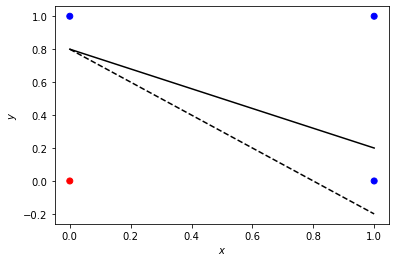

In [3]:
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
targets = np.array([[0],[1],[1],[1]])
colors = []
for i in range(len(targets)):
    colors.append(['red','blue'][targets[i][0]])
plt.scatter(inputs[:,0],inputs[:,1],color=colors)
plt.plot([0,1],[0.8,0.2],c='k')
plt.plot([0,1],[0.8,-0.2],'--',c='k')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Line of the form $w_0 x + w_1 y - w_2 = 0$ or $y = -w_0/w_1 x + w_2/w_1$.

The solid line mis-classifies one point. To get this classification right, the line needs to become steeper for the point with $x=1$ and $y=0$.

To make the line steeper, $w_0$ needs to increase:

\begin{equation}
\label{eq:1}
w_0 = w_0 - \eta (0-1) * 1 = w_0 + \eta
\end{equation}

If we give the model a new point, it will predict &ldquo;blue&rdquo; if the point is above the line and &ldquo;red&rdquo; if it is below.



### example neural network: confusion matrix



We import some data:



In [37]:
import requests
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
r = requests.get(url, allow_redirects=True)
filename = "./data/iris.csv"
open(filename, 'wb').write(r.content)

df = pd.read_csv(filename, header=None, names=['sepal_length','sepal_width','petal_length','petal_width','species'])
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


* how many observations do we have?
* what are the datatypes of the columns (hint: use `dtypes`)
* how can we figure out the number of species ('targets') that we have?

In [38]:
df.shape

(150, 5)

In [39]:
df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [40]:
df.species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [41]:
df["species"].replace({"Iris-setosa":0,"Iris-virginica":1,"Iris-versicolor":2},inplace=True)
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1
149,5.9,3.0,5.1,1.8,1


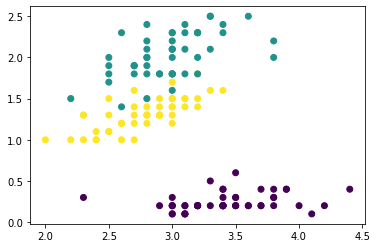

In [42]:
plt.scatter(df['sepal_width'],df['petal_width'],c=df.species);

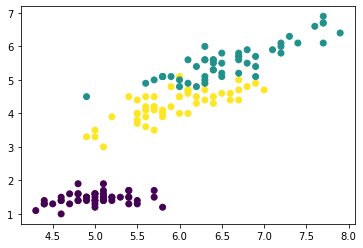

In [43]:
plt.scatter(df['sepal_length'],df['petal_length'],c=df.species);

In [45]:
#plt.scatter?

-   Neural networks do not only use linear functions to separate the data
-   [https://playground.tensorflow.org/](https://playground.tensorflow.org/)

Before estimating a neural network, it is a good idea to standardize the features. No need to standardize the labels.



In [46]:
X = np.zeros([150,4])
i = 0
for col in df.columns[0:4]:
    x = df[col].values
    X[:,i] = (x-x.mean())/x.std()
    i += 1

y = df['species'].values

-   Ignoring for now splitting the data into test and train set



In [47]:
model = keras.Sequential([
    keras.layers.Dense(20, input_dim = 4, activation='relu'), # input layer
    keras.layers.Dense(10, activation = 'relu'),              # hidden
    keras.layers.Dense(3, activation = 'softmax')             # output
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.fit(X,y,epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 15ms/step - loss: 1.3436 - accuracy: 0.0267
Epoch 2/10
5/5 [==============================] - 0s 1ms/step - loss: 1.2665 - accuracy: 0.0600
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 1.1983 - accuracy: 0.1600
Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 1.1345 - accuracy: 0.3067
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 1.0772 - accuracy: 0.4133
Epoch 6/10
5/5 [==============================] - 0s 1ms/step - loss: 1.0230 - accuracy: 0.4533
Epoch 7/10
5/5 [==============================] - 0s 21ms/step - loss: 0.9770 - accuracy: 0.5067
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 0.9347 - accuracy: 0.5467
Epoch 9/10
5/5 [==============================] - 0s 20ms/step - loss: 0.8966 - accuracy: 0.5667
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.8631 - accuracy: 0.5933


In [50]:
y_pred = (model.predict(X)).argmax(axis=1)
matrix = tf.math.confusion_matrix(y, y_pred)
matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[50,  0,  0],
       [ 9, 41,  0],
       [ 7, 43,  0]], dtype=int32)>

In [52]:
#tf.math.confusion_matrix?

In [49]:
model.predict(X)

array([[0.5911184 , 0.295668  , 0.11321361],
       [0.5272502 , 0.3122293 , 0.16052057],
       [0.59597796, 0.2960006 , 0.10802138],
       [0.58721024, 0.29916742, 0.11362233],
       [0.6237827 , 0.28054452, 0.09567276],
       [0.6512037 , 0.24660213, 0.10219412],
       [0.64591324, 0.2704632 , 0.08362364],
       [0.58503014, 0.29803678, 0.11693307],
       [0.5790522 , 0.30560595, 0.11534184],
       [0.5435964 , 0.30876505, 0.14763851],
       [0.58658385, 0.291503  , 0.12191315],
       [0.61182255, 0.2858076 , 0.10236976],
       [0.54296833, 0.30822256, 0.1488091 ],
       [0.61453056, 0.29223007, 0.09323942],
       [0.61903393, 0.25940672, 0.12155931],
       [0.77975696, 0.1600838 , 0.06015928],
       [0.6566275 , 0.24816623, 0.09520628],
       [0.5939104 , 0.29409885, 0.11199073],
       [0.5738066 , 0.28099263, 0.14520076],
       [0.65756583, 0.25605518, 0.08637901],
       [0.51232964, 0.31822997, 0.16944046],
       [0.6372637 , 0.2692244 , 0.09351191],
       [0.

### using history to check for over/under fitting



-   neural network with the handwritten digits data set
-   use `history` method to fine tune the number of epochs to avoid under/over-fitting



In [16]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(train_images,
                    train_labels,
                    epochs=60,
                    batch_size=512,
                    validation_data=(test_images, test_labels))

Epoch 1/60
118/118 [==============================] - 5s 34ms/step - loss: 9.4810 - accuracy: 0.8256 - val_loss: 2.3231 - val_accuracy: 0.9088
Epoch 2/60
118/118 [==============================] - 3s 26ms/step - loss: 1.7549 - accuracy: 0.9183 - val_loss: 1.4552 - val_accuracy: 0.9214
Epoch 3/60
118/118 [==============================] - 3s 27ms/step - loss: 1.0056 - accuracy: 0.9358 - val_loss: 1.1309 - val_accuracy: 0.9366
Epoch 4/60
118/118 [==============================] - 3s 24ms/step - loss: 0.6812 - accuracy: 0.9484 - val_loss: 1.0197 - val_accuracy: 0.9332
Epoch 5/60
118/118 [==============================] - 3s 24ms/step - loss: 0.5054 - accuracy: 0.9559 - val_loss: 0.8466 - val_accuracy: 0.9440
Epoch 6/60
118/118 [==============================] - 3s 22ms/step - loss: 0.3677 - accuracy: 0.9640 - val_loss: 0.7861 - val_accuracy: 0.9450
Epoch 7/60
118/118 [==============================] - 3s 23ms/step - loss: 0.2871 - accuracy: 0.9671 - val_loss: 0.7494 - val_accuracy: 0.9490

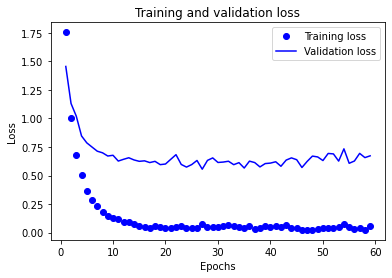

In [17]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### TODO experiment with architecture: number of nodes and layers; e.g. try to over- or under-fit



### treatment effects:



-   to stress the difference between prediction (above) and causality, we finish with a causal problem
    -   we program our own data to see how IV works in identifying causal effects
    -   what can we identify if the effects of a program differ by group?

When examining the effect of education (e) on wage rate (w), there can be a confounding effect: personal motivation (u). This we call a &ldquo;fork&rdquo;. Regressing $e$ on $w$ will not give us the effect of education on the income you will earn.

But if you want to predict wage, make sure you include education in your regression!

We need an exogenous variation in $e$ to find the causal effect: e.g. the month that you go to (or leave) school.

-   we generate our own data where $e$ has no effect on $w$
-   running the regression of $w$ on $e$ shows that a correlation exists
-   using an instrumental variable, we recover that this correlation is not a causal effect
-   the assumption here is that the effect of $e$ on $w$ is the same for everyone

Heterogeneous treatment effects:

-   we allow different groups of unemployed (compliers, always-takers and never-takers) to be affected differently by training
-   under which conditions can we identify the correct effects of training?

We generate the data with:



In [27]:
def accept_complier(invited):
    return invited

def accept_always(invited):
    return np.ones_like(invited)

def accept_never(invited):
    return np.zeros_like(invited)

N_simulations = 10000
fraction_training = 0.2 # 20% of agents are invited to the training
types = ['complier','always_taker', 'never_taker']
β = {'complier': 1, 'always_taker': 2, 'never_taker': 1}
τ = {'complier': 3, 'always_taker': 4, 'never_taker': 1}
n = {'complier': 0.5, 'always_taker': 0.25, 'never_taker': 0.25}
accept = {'complier': accept_complier, 'always_taker': accept_always, 'never_taker': accept_never} # note that this dictionary returns a function
earnings_without = {}
training_effect = {}
earnings = {}
invited = {}
trained = {}
df = pd.DataFrame()
def data_simulation(β = β, τ=τ, n = n):
    for j in types:
        earnings_without[j] = np.random.normal(loc = β[j], scale = 1.0, size = int(n[j]*N_simulations))
        training_effect[j] = np.random.normal(loc = τ[j], scale = 1.0, size = int(n[j]*N_simulations))
        invited[j] = np.random.binomial(1,fraction_training,size = int(n[j]*N_simulations))
        trained[j] = accept[j](invited[j])
        earnings[j] = earnings_without[j] + trained[j]*training_effect[j]
    column_invited = np.concatenate([invited[j] for j in types],axis=0)
    column_trained = np.concatenate([trained[j] for j in types],axis=0)
    column_earnings = np.concatenate([earnings[j] for j in types],axis=0)
    df = pd.DataFrame({'invited':column_invited, 'trained':column_trained,'earnings':column_earnings})
    return df

df = data_simulation()
df.head()

,invited,trained,earnings
0,1,1,4.917681
1,0,0,2.076008
2,0,0,0.491808
3,0,0,-0.269131
4,0,0,0.092641


Once we have this data, we can try different identification measures to see which of the parameters above we can recover from the data in the dataframe.

| |%|trained|untrained| β | β + τ |
|---|---|---|---|---|---|
| complier|0.5|0.1|0.4|1|4|
| always taker|0.25|0.25|0|2|6|
| never taker|0.25|0|0.25|1|2|

In the notebook we go over a number of estimation techniques to see under which conditions a given technique can recover the relevant parameter values.



## aside: setting seed for random numbers

When you run the code above, you will get different random numbers from the ones above. If you want to avoid this (e.g. to make your results reproducible for someone else), you can set a seed:

In [53]:
print(np.random.normal(0,1,size=5))
print(np.random.normal(0,1,size=5))

[ 1.65143654 -2.42667924 -0.42891263  1.26593626 -0.8667404 ]
[-0.67888615 -0.09470897  1.49138963 -0.638902   -0.44398196]


In [55]:
np.random.seed(123)
print(np.random.normal(0,1,size=5))
print(np.random.normal(0,1,size=5))
np.random.seed(123)
print(np.random.normal(0,1,size=5))
print(np.random.normal(0,1,size=5))

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025]
[ 1.65143654 -2.42667924 -0.42891263  1.26593626 -0.8667404 ]
[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025]
[ 1.65143654 -2.42667924 -0.42891263  1.26593626 -0.8667404 ]


# next lecture: getting data



#### TODO upload `country_code.py` file on jupyterlab



We look at the data for each variable, decide on the shape we want to have for the dataframe and then merge a number of data sets together. For this we will be using pandas. Further, we use the python file `country_codes.py` which should be in the same folder as this notebook.

We focus on the following countries when looking at the data. For the Eurostat data this does not matter so much. But if you want to combine Eurostat data with OECD data, this selection can be useful.



In [56]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

#### Mortality



The [Eurostat website](https://ec.europa.eu/eurostat/data/database?node_code=hlth_cd_apr) has a browser where you can look for data. Here we are looking for data on mortality. You can click on the link to the data browser to see the [details of the variable](https://ec.europa.eu/eurostat/databrowser/view/hlth_cd_apr/default/table?lang=en). At the top-left of the screen you can see the name of the variable in the line &ldquo;`online data code: HLTH_CD_APR`&rdquo;. The name of this variable we use below in the `get_data_df` method.

So we call this method and collect the information in the dataframe `df`. Then we check what `df` looks like:



In [57]:
df = eurostat.get_data_df('hlth_cd_apr')
df.head()

,mortalit,sex,icd10,unit,geo\time,2018,2017,2016,2015,2014,2013,2012,2011
0,PRVT,F,A00-A09,NR,AT,8.0,10.0,15.0,5.0,6.0,9.0,12.0,7.0
1,PRVT,F,A00-A09,NR,BE,26.0,45.0,27.0,26.0,26.0,20.0,11.0,25.0
2,PRVT,F,A00-A09,NR,BG,3.0,4.0,7.0,13.0,11.0,10.0,4.0,5.0
3,PRVT,F,A00-A09,NR,CH,11.0,13.0,13.0,5.0,9.0,9.0,14.0,14.0
4,PRVT,F,A00-A09,NR,CY,2.0,2.0,0.0,0.0,0.0,1.0,1.0,6.0


We would like to get our data into the following shape:

| country|year|sex|Preventable  mortality|Treatable  mortality|
|---|---|---|---|---|
| Austria|2011|F|95.29|67.41|
| Austria|2011|M|248.50|96.86|
| Austria|2012|F|96.16|69.72|
| Austria|2012|M|252.28|91.45|
| Austria|2013|F|93.22|66.84|

Hence we need to use pandas to get from our initial `df` to a dataframe like this table. The good news is that we will download a number of variables so that we can practice a lot!

So we have a number of columns with abbreviations in them and then we have data for the years 2011-2017. Use the website of the variable to figure out what the abbreviations mean. To illustrate, the column `mortalit` gives three measures of mortality:



In [58]:
df.mortalit.unique()

array(['PRVT', 'TOTAL', 'TRT'], dtype=object)

We will be interested in preventable &rsquo;PRVT&rsquo; and treatable &rsquo;TRT&rsquo; mortality.

First, let&rsquo;s change the country column `geo\time` and use country names instead of abbreviations. We need to &ldquo;escape&rdquo; the &rsquo;\\&rsquo; symbol to make sure pandas reads &rsquo;\\&rsquo; literally (not as a symbol). That is why we have &rsquo;\\\\&rsquo; in the code below. We use the `eurostat_dictionary` to turn the country abbreviations into country names.

Note that to change the column name we use `.rename`; to change values in a row, we use `.replace`. The replacements are provided using a python dictionary: `{'old_name':'new_name'}`.

If you are wondering why we use `inplace=True`, just run the code block without this to see the difference.



In [33]:
df.rename({'geo\\time':'geo'},inplace=True,axis=1)
df['country'] = df['geo'].replace(eurostat_dictionary)
df.head()

,mortalit,sex,icd10,unit,geo,2018,2017,2016,2015,2014,2013,2012,2011,country
0,PRVT,F,A00-A09,NR,AT,8.0,10.0,15.0,5.0,6.0,9.0,12.0,7.0,Austria
1,PRVT,F,A00-A09,NR,BE,26.0,45.0,27.0,26.0,26.0,20.0,11.0,25.0,Belgium
2,PRVT,F,A00-A09,NR,BG,3.0,4.0,7.0,13.0,11.0,10.0,4.0,5.0,Bulgaria
3,PRVT,F,A00-A09,NR,CH,11.0,13.0,13.0,5.0,9.0,9.0,14.0,14.0,Switzerland
4,PRVT,F,A00-A09,NR,CY,2.0,2.0,0.0,0.0,0.0,1.0,1.0,6.0,Cyprus


### aside: what is \t?

In the example above, we need to "escape" `\time` for the following reason:

In [61]:
print('geo\time')
print('geo\\time')

geo	ime
geo\time


Now we will select the values that we are interested in: only EU countries, both males and females, both preventable and treatable mortality, unit of measurement rate &rsquo;RT&rsquo; (not number &rsquo;NR&rsquo;) and all diseases (e.g. not the subset &ldquo; [A00-A09] Intestinal infectious diseases&rdquo;).

For selection, we can use `==` or `.isin()`. With numbers we can also use smaller/greater than `<,>` etc.

After this selection, we can drop some columns to make the dataframe a bit easier to handle.



In [35]:
df = df[df.country.isin(EU_countries) & (df.sex.isin(["M","F"]) ) & (df.mortalit.isin(["PRVT","TRT"])) \
        & (df.unit == "RT") & (df.icd10 == "TOTAL")]
df.drop(["unit","icd10","geo"],axis=1,inplace=True)
df.head()

,mortalit,sex,2018,2017,2016,2015,2014,2013,2012,2011,country
6300,PRVT,F,93.11,92.94,96.39,97.52,93.95,93.22,96.16,95.29,Austria
6301,PRVT,F,92.58,93.42,94.13,99.71,95.40,100.34,99.97,101.35,Belgium
6302,PRVT,F,119.02,121.87,120.14,128.32,129.04,119.29,126.17,119.32,Bulgaria
6303,PRVT,F,70.94,68.45,68.91,69.37,72.70,73.85,74.02,73.75,Switzerland
6304,PRVT,F,50.87,46.69,49.98,55.67,54.65,47.75,49.38,57.31,Cyprus
